In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
filedir = '/content/drive/My Drive/dacon'

# 데이터 불러오기

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

data_train = pd.read_csv(filedir+'/train.csv')
data_test = pd.read_csv(filedir+'/test.csv')
print(data_train.shape)
data_train.head(5).transpose()

(1108, 22)


,0,1,2,3,4
id,0,1,2,3,4
Year_Birth,1974,1962,1951,1974,1946
Education,Master,Graduation,Graduation,Basic,PhD
Marital_Status,Together,Single,Married,Married,Together
Income,46014.0,76624.0,75903.0,18393.0,64014.0
Kidhome,1,0,0,1,2
Teenhome,1,1,1,0,1
Dt_Customer,21-01-2013,24-05-2014,08-04-2013,29-03-2014,10-06-2014
Recency,21,68,50,2,56
NumDealsPurchases,10,1,2,2,7


### target overview

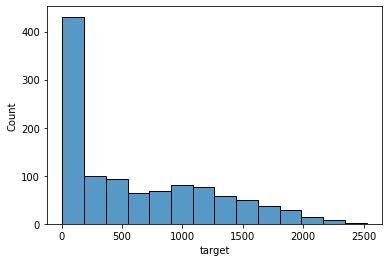

In [4]:
sns.histplot(data_train['target'])

target 변수(소비량)를 250, 100, 1800 기준으로 구간을 나누어 1,2,3,4 로 Labeling함.

In [5]:
data_train_T=data_train['target']
target=[]
for i in range(len(data_train_T)):
    if data_train_T.iloc[i] < 250:
        target.append(1)
    elif data_train_T.iloc[i] < 1000:
        target.append(2)
    elif data_train_T.iloc[i] < 1800:
        target.append(3)
    else:
        target.append(4)
        
data_train["Range"] = target

# 데이터 전처리

### Year_Birth를 이용해 나이 Age 계산하기

In [6]:
data_train['Age'] = 2022 - data_train['Year_Birth']
data_test['Age'] = 2022 - data_train['Year_Birth']

### 문자 자료형 Education, Marital_Status 숫자로 인코딩 하기

In [7]:
data_train['Education'].value_counts()

Graduation    570
PhD           254
Master        173
2n Cycle       89
Basic          22
Name: Education, dtype: int64

label encoding 사용하여 학사->석사->박사 순으로 인코딩
- 학사 = 0, Basic, Graduation
- 석사 = 1, 2n Cycle, Master
- 박사 = 2, PhD

In [8]:
#train set 및 test set에 적용
for data in [data_train, data_test]:
    for i in range(data.shape[0]):
        education = data['Education'].iloc[i]
        if education in ["Basic", "Graduation"]:
            data['Education'].iloc[i] = 0
        elif education in ["2n Cycle", "Master"]:
            data['Education'].iloc[i] = 1
        else:
            data['Education'].iloc[i] = 2

---

In [9]:
data_train['Marital_Status'].value_counts()

Married     415
Together    296
Single      234
Divorced    120
Widow        39
Alone         2
YOLO          1
Absurd        1
Name: Marital_Status, dtype: int64

결혼 유무를 이진화

- 결혼, 동거 = 0, Married, Together
- 싱글 = 1, Single, Divorced, Widow, Alone, YOLO, Absurd

In [10]:
#train set 및 test set에 적용
for data in [data_train, data_test]:
    for i in range(data.shape[0]):
        marital_status = data['Marital_Status'].iloc[i]
        if marital_status in ["Married", "Together"]:
            data['Marital_Status'].iloc[i] = 0
        else:
            data['Marital_Status'].iloc[i] = 1

### 타임스탬프 Dt_Customer를 회사 가입 개월수인 Sign_Month로 변환
sign_month = 사이트에 가입하고 몇개월이나 지났는가? 높을수록 예전에 가입한사람
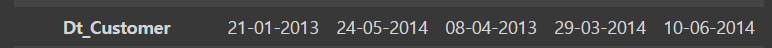

In [11]:
for data in [data_train, data_test]:
    for i in range(data.shape[0]):
        data['Dt_Customer'].iloc[i] = int(data['Dt_Customer'].iloc[i][-1]) * 12 + int(data['Dt_Customer'].iloc[i][3:5])
        
recent_month = max(data_train['Dt_Customer'])

for data in [data_train, data_test]:
    month_arr = []
    for i in range(data.shape[0]):
        month_arr.append(recent_month - data['Dt_Customer'].iloc[i])
        
    data['Sign_Month'] = month_arr

### 상관관계 살펴보기
target과 feature의 상관관계를 살펴봅시다

In [12]:
corr_matrix = data_train.corr()
corr_matrix["target"].sort_values(ascending=False)

target                 1.000000
Range                  0.954404
NumCatalogPurchases    0.798065
Income                 0.784084
NumStorePurchases      0.677785
NumWebPurchases        0.546082
AcceptedCmp5           0.458208
AcceptedCmp1           0.361102
AcceptedCmp4           0.256784
Response               0.242760
Sign_Month             0.176342
Age                    0.136035
AcceptedCmp2           0.129995
Recency                0.050873
AcceptedCmp3           0.040736
id                     0.034192
Complain              -0.058704
NumDealsPurchases     -0.072802
Teenhome              -0.109214
Year_Birth            -0.136035
NumWebVisitsMonth     -0.488252
Kidhome               -0.538365
Name: target, dtype: float64

In [13]:
def maximum_absolute_scaling(df):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        if column != "Range":
            df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled

### 필요없는 feature 버리기

In [14]:
data_train = data_train.drop(["id", "Dt_Customer", "Year_Birth"], axis = 1)
data_test = data_test.drop(["id", "Dt_Customer", "Year_Birth"], axis = 1)

### 데이터셋 X, Y 나누기

In [15]:
data_train_X = data_train.drop(["target"], axis = 1)
data_train_y = data_train["target"]

### NN 사용을 위해 데이터 0~1 범위로 변환하기

반드시 train 데이터셋의 max값을 사용하여 train과 test셋을 나눠줍니다

In [16]:
data_train_X.head(5)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Range,Age,Sign_Month
0,1,0,46014.0,1,1,21,10,7,1,8,...,0,0,0,0,0,0,0,2,48,17
1,0,1,76624.0,0,1,68,1,5,10,7,...,1,0,0,0,0,0,0,2,60,1
2,0,0,75903.0,0,1,50,2,6,6,9,...,0,0,0,0,0,0,0,2,71,14
3,0,0,18393.0,1,0,2,2,3,0,3,...,0,0,0,0,0,0,0,1,48,3
4,2,0,64014.0,2,1,56,7,8,2,5,...,0,0,0,1,0,0,0,2,76,0


In [17]:
data_test.head(5)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Sign_Month
0,0,1,57537.0,1,0,83,4,4,3,8,4,0,0,0,0,0,0,0,48,12
1,0,0,65748.0,0,1,58,2,2,4,10,1,0,0,0,0,0,1,0,60,14
2,0,0,55434.0,1,0,21,3,5,3,13,4,0,0,0,0,0,0,0,71,8
3,0,0,67716.0,0,1,8,4,7,4,13,5,0,1,0,0,0,0,0,48,17
4,0,0,85606.0,0,1,89,2,6,7,9,3,0,0,0,1,0,0,0,76,19


In [18]:
df_scaled = data_train_X.copy()

for column in df_scaled.columns:
    if column != "Range":
        data_train_X[column] = data_train_X[column] / df_scaled[column].abs().max()
        data_test[column] = data_test[column] / df_scaled[column].abs().max()

In [19]:
data_train_X.head(5)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Range,Age,Sign_Month
0,0.5,0.0,0.283343,0.5,0.5,0.212121,0.666667,0.259259,0.090909,0.615385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.372093,0.739130
1,0.0,1.0,0.471831,0.0,0.5,0.686869,0.066667,0.185185,0.909091,0.538462,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.465116,0.043478
2,0.0,0.0,0.467392,0.0,0.5,0.505051,0.133333,0.222222,0.545455,0.692308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.550388,0.608696
3,0.0,0.0,0.113259,0.5,0.0,0.020202,0.133333,0.111111,0.000000,0.230769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.372093,0.130435
4,1.0,0.0,0.394182,1.0,0.5,0.565657,0.466667,0.296296,0.181818,0.384615,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0.589147,0.000000


In [20]:
data_test.head(5)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Sign_Month
0,0.0,1.0,0.354298,0.5,0.0,0.838384,0.266667,0.148148,0.272727,0.615385,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.372093,0.521739
1,0.0,0.0,0.404860,0.0,0.5,0.585859,0.133333,0.074074,0.363636,0.769231,0.05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.465116,0.608696
2,0.0,0.0,0.341349,0.5,0.0,0.212121,0.200000,0.185185,0.272727,1.000000,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.550388,0.347826
3,0.0,0.0,0.416978,0.0,0.5,0.080808,0.266667,0.259259,0.363636,1.000000,0.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.372093,0.739130
4,0.0,0.0,0.527140,0.0,0.5,0.898990,0.133333,0.222222,0.636364,0.692308,0.15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.589147,0.826087


# 모델 생성 및 학습하기

### 평가방법인 NMAE 정의

In [21]:
def NMAE(true, pred):
    score = np.mean(np.abs(true - pred) / true)
    return score

### DNN 모델을 15 k-fold로 soft-voting

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

import tensorflow as tf

tf.random.set_seed(42)
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True) #총 5번의 fold 진행
n = 0 #x번째 fold인지 기록

fold_target_pred = []
fold_score = []

for train_index, valid_index in skf.split(data_train_X, data_train_X['Range']):
    n += 1
    
    val_pred_name = [] #validation pred model 이름 저장
    val_pred = []      #validation set pred 결과 저장
    target_pred = []   #test set pred 결과 저장
    
    train_X = np.array(data_train_X.drop("Range", axis = 1)).astype(float) #분배된 학습을 위해 만들어둔 Range feature 제거
    train_Y = np.array(data_train_y).astype(float)
    
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_Y[train_index], train_Y[valid_index]
    
    X_test = np.array(data_test).astype(float)

    ### Create Model ###
    
    model = Sequential()
    model.add(Dense(32, input_dim=20, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_absolute_error',
                  optimizer = 'Nadam', 
                  metrics=['mae'])
    
    filename = 'nn-checkpoint.h5'
    checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                                monitor='val_mae',   # val_accuracy 값이 개선되었을때 호출됩니다
                                verbose=0,            # 로그를 출력합니다
                                save_best_only=True,  # 가장 best 값만 저장합니다
                                mode='min'           # 평가모델이 mae이기 때문에 값이 작을때만 저장합니다 (min)
                               )

    earlystopping = EarlyStopping(monitor='val_mae', #stop 조건으로 관찰할 변수 선택
                                 patience=120,       #120 Epoch동안 (mae가)개선되지 않는다면 종료
                                 mode='min'
                                )

    reduceLR = ReduceLROnPlateau(monitor='val_mae', #lr을 낮출 조건으로 관찰할 변수 선택
                                factor=0.5,             #조건이 충족되었을때 LR에 factor를 곱함 (5분의 1배가 됨)
                                patience=80,  #80 Epoch동안 (mae가)개선되지 않는다면 lr 감소
                                mode='min'
                               )
    
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=3000, batch_size=32, verbose = 0, callbacks=[earlystopping, checkpoint, reduceLR])

    val_pred_name.append("NN")  # 모델 이름 저장
    val_pred.append(model.predict(X_valid).flatten())   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test).flatten()) # test set pred 결과 저장
    
    ### average validation pred ###
    preds = np.array(val_pred[0])
    
    ### average target pred ###
    target_preds = target_pred[0]
    fold_target_pred.append(target_preds) # append final target pred
    
    print("========== fold %d ==========" %(n))
    for i in range(len(val_pred)):
        print("%s model NMAE : %0.4f" %(val_pred_name[i], NMAE(y_valid, val_pred[i].astype(int))))
        
    print("==============================")
    print("Average NMAE with Round Down %0.4f" %(NMAE(y_valid, preds.astype(int))))
    print("Average NMAE with Round %0.4f" %(NMAE(y_valid, np.round(preds))))
    print("")
    
    fold_score.append(NMAE(y_valid, preds.astype(int)))

total_score = fold_score[0]
for i in range(1, len(fold_score)):
    total_score += fold_score[i]
    
total_score = total_score/len(fold_score)

print("==============================")
print("Model Sum Average NMAE %0.4f" %(total_score))

========== fold 1 ==========
NN model NMAE : 0.3036
Average NMAE with Round Down 0.3036
Average NMAE with Round 0.3073

========== fold 2 ==========
NN model NMAE : 0.2379
Average NMAE with Round Down 0.2379
Average NMAE with Round 0.2396

========== fold 3 ==========
NN model NMAE : 0.2680
Average NMAE with Round Down 0.2680
Average NMAE with Round 0.2707

========== fold 4 ==========
NN model NMAE : 1.6318
Average NMAE with Round Down 1.6318
Average NMAE with Round 1.6366

========== fold 5 ==========
NN model NMAE : 0.2873
Average NMAE with Round Down 0.2873
Average NMAE with Round 0.2861

Model Sum Average NMAE 0.5457


# 제출하기

In [23]:
### average target pred ###
final_pred = np.array(fold_target_pred[0])
for i in range(1, len(fold_target_pred)):
    final_pred += fold_target_pred[i]

final_pred = final_pred/len(fold_target_pred)
final_pred = np.round(final_pred)

In [24]:
y_valid.shape

(73,)

### 마지막 모델 학습때 예측한 Valid Set 정확도 시각화
label의 값이 높아질수록 예측을 정확하게 못하는 모습을 보임

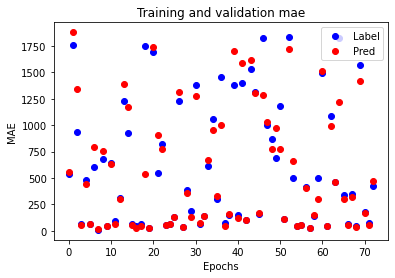

In [25]:
plt.plot(y_valid, 'bo', label='Label')
plt.plot(np.round(preds), 'ro', label='Pred')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [26]:
submission = pd.read_csv(filedir+"/sample_submission.csv")
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [27]:
submission['target'] = final_pred
submission.head()

,id,target
0,0,516.0
1,1,630.0
2,2,777.0
3,3,1150.0
4,4,1382.0


In [28]:
submission.to_csv("Submit_13.csv",index=False)